In [1]:
#Imports 
import numpy as np
import random as rand
import matplotlib.pyplot as plt

### Ejercicio No.2

### Inciso 1 y 2

In [28]:
# darcy
# Función que simula el flujo de Darcy en un medio poroso
def darcy_flow(L, A, k, P_left, P_right, dx, dt, total_time):
    
    # Número de puntos en la malla espacial y temporal
    Nx = int(L / dx) + 1
    Nt = int(total_time / dt) + 1

    # Inicializar la matriz de presión
    P = np.zeros((Nt, Nx))

    # Condiciones iniciales y de contorno
    P[:, 0] = P_left
    P[:, -1] = P_right

    # Simulación usando un esquema explícito en diferencias finitas
    for n in range(0, Nt - 1):
        for i in range(1, Nx - 1):
            # Calcular el gradiente de presión
            dP_dx = (P[n, i+1] - P[n, i-1]) / (2 * dx)
            
            # Calcular el caudal según la Ley de Darcy
            Q = -k * A * dP_dx
            
            # Actualizar la presión
            P[n + 1, i] = P[n, i] - (Q / A) * dt

    return P

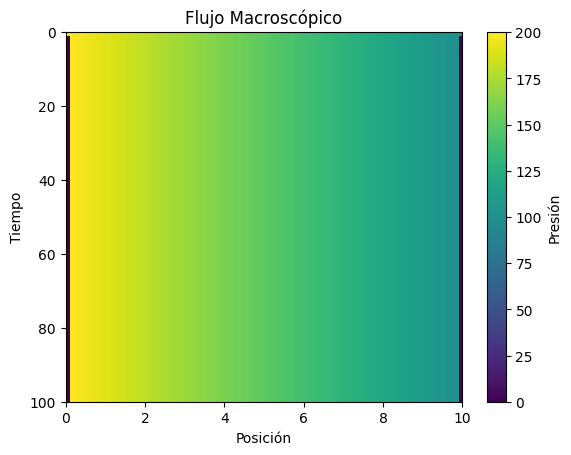

In [52]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetros generales del problema
L = 10.0  # Longitud de la formación rocosa (m)
A = 1.0  # Área de sección transversal (m^2)
k = 1e-12  # Permeabilidad del medio (m^2)
P_left = 200e5  # Presión en el extremo izquierdo (Pa)
P_right = 100e5  # Presión en el extremo derecho (Pa)
dx = 0.1  # Tamaño del paso espacial (m)
dt = 1.0  # Tamaño del paso temporal (s)
total_time = 100.0  # Tiempo total de simulación (s)

# Crear una malla de posiciones
x = np.linspace(0, L, int(L / dx) + 1)

# Inicializar la matriz de presión con condiciones iniciales
P = np.zeros((int(total_time / dt) + 1, len(x)))
P[0, :] = P_left + (P_right - P_left) * x / L

# Ejecutar la simulación del flujo de agua utilizando la Ley de Darcy
for t in range(0, P.shape[0] - 1):
    for i in range(1, len(x) - 1):
        dP_dx = (P[t, i+1] - P[t, i-1]) / (2 * dx)
        Q = -k * A * dP_dx
        P[t + 1, i] = P[t, i] - (Q / A) * dt

# Visualización de los resultados
plt.imshow(P / 1e5, cmap='viridis', extent=[0, L, total_time, 0], aspect='auto')
plt.colorbar(label='Presión')
plt.xlabel('Posición')
plt.ylabel('Tiempo')
plt.title("Flujo Macroscópico")
plt.show()


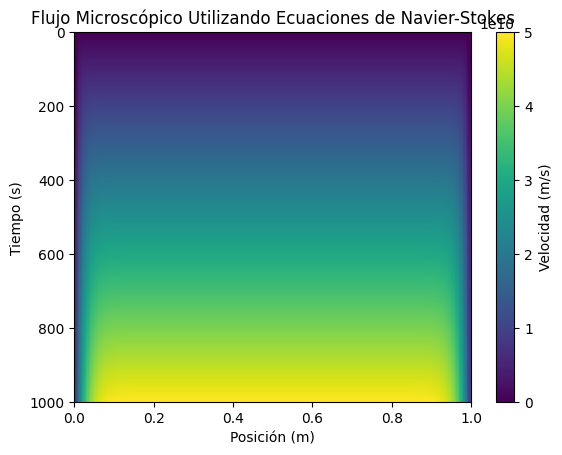

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve_banded

def simulate_microscopic_flow(length, viscosity_fluid, inlet_pressure, outlet_pressure, spatial_step, time_step, total_time):
    # numero de puntos en la malla espacial y temporal
    num_x_points = int(length / spatial_step) + 1
    num_time_steps = int(total_time / time_step) + 1

    # inicializar la matriz de velocidad
    velocity_field = np.zeros((num_time_steps, num_x_points))

    # condiciones iniciales (velocidad inicial en todo el dominio)
    velocity_field[0, :] = 0.0

    # coeficientes para el método implícito
    alpha = viscosity_fluid * time_step / (2 * spatial_step ** 2)
    beta = time_step / (2 * spatial_step)

    # preparar la matriz tridiagonal
    ab = np.zeros((3, num_x_points))
    ab[0, 1:] = -alpha  # Diagonal inferior
    ab[1, :] = 1 + 2 * alpha  # Diagonal principal
    ab[2, :-1] = -alpha  # Diagonal superior

    # bucle principal de la simulación
    for n in range(0, num_time_steps - 1):
        # crear el vector b del sistema Ax = b
        b = velocity_field[n, :]
        b[1:-1] += alpha * (velocity_field[n, :-2] - 2 * velocity_field[n, 1:-1] + velocity_field[n, 2:])
        b[1:-1] += beta * (inlet_pressure - outlet_pressure) / length

        # resolver el sistema lineal para encontrar la nueva velocidad
        velocity_field[n + 1, :] = solve_banded((1, 1), ab, b)

    return velocity_field

# parametros de simulación
length = 1.0
viscosity_fluid = 1e-6
spatial_step = 0.01
time_step = 0.1
total_time = 1000.0
inlet_pressure = 20e5
outlet_pressure = 10e5

# ver resultados
velocity_field = simulate_microscopic_flow(length, viscosity_fluid, inlet_pressure, outlet_pressure, spatial_step, time_step, total_time)
plt.imshow(velocity_field, extent=[0, length, total_time, 0], aspect='auto')
plt.colorbar(label='Velocidad (m/s)')
plt.xlabel('Posición (m)')
plt.ylabel('Tiempo (s)')
plt.title('Flujo Microscópico Utilizando Ecuaciones de Navier-Stokes')
plt.show()


### Inciso 3

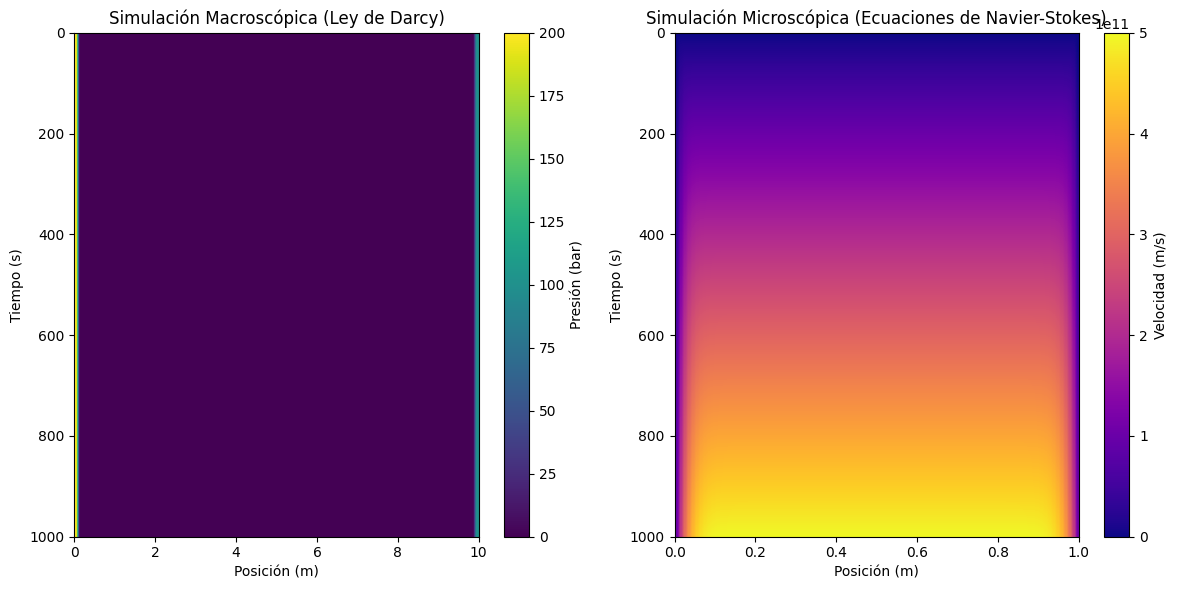

In [61]:
import numpy as np
import matplotlib.pyplot as plt

# Función para realizar la simulación multiescala concurrente
def multiscale_simulation(L_macro, A, k, P_left, P_right, dx_macro, dt_macro, total_time, L_micro, density_fluid, viscosity_fluid, dx_micro, dt_micro, total_time_micro):
    # Simulación macroscópica usando la Ley de Darcy
    P_macro = darcy_flow(L_macro, A, k, P_left, P_right, dx_macro, dt_macro, total_time)

    # Obtener la presión en el extremo derecho de la simulación macroscópica
    P_macro_right = P_macro[-1, -1]

    # Simulación microscópica usando las ecuaciones de Navier-Stokes
    velocity_field_micro = simulate_microscopic_flow(L_micro, viscosity_fluid, P_left, P_macro_right, dx_micro, dt_micro, total_time_micro)

    return P_macro, velocity_field_micro

# Parámetros de simulación macroscópica
L_macro = 10.0  # Longitud de la formación rocosa (m)
A = 1.0  # Área de sección transversal (m^2)
k = 1e-12  # Permeabilidad del medio (m^2)
P_left = 200e5  # Presión en el extremo izquierdo (Pa)
P_right = 100e5  # Presión en el extremo derecho (Pa)
dx_macro = 0.1  # Tamaño del paso espacial macroscópico (m)
dt_macro = 1.0  # Tamaño del paso temporal macroscópico (s)
total_time = 1000.0  # Tiempo total de simulación macroscópica (s)

# Parámetros de simulación microscópica
L_micro = 1.0  # Longitud del segmento en metros
density_fluid = 1000.0  # Densidad del fluido en kg/m^3
viscosity_fluid = 1e-6  # Viscosidad cinemática en m^2/s
dx_micro = 0.01  # Tamaño del paso espacial microscópico (m)
dt_micro = 0.1  # Tamaño del paso temporal microscópico (s)
total_time_micro = 1000.0  # Tiempo total de simulación microscópica (s)

# Realizar la simulación multiescala concurrente
P_macro, velocity_field_micro = multiscale_simulation(L_macro, A, k, P_left, P_right, dx_macro, dt_macro, total_time, L_micro, density_fluid, viscosity_fluid, dx_micro, dt_micro, total_time_micro)

# Visualización de resultados
plt.figure(figsize=(12, 6))

# Gráfico de la simulación macroscópica (presión)
plt.subplot(1, 2, 1)
plt.imshow(P_macro / 1e5, cmap='viridis', extent=[0, L_macro, total_time, 0], aspect='auto')
plt.colorbar(label='Presión (bar)')
plt.xlabel('Posición (m)')
plt.ylabel('Tiempo (s)')
plt.title("Simulación Macroscópica (Ley de Darcy)")

# Gráfico de la simulación microscópica (velocidad)
plt.subplot(1, 2, 2)
plt.imshow(velocity_field_micro, cmap='plasma', extent=[0, L_micro, total_time_micro, 0], aspect='auto')
plt.colorbar(label='Velocidad (m/s)')
plt.xlabel('Posición (m)')
plt.ylabel('Tiempo (s)')
plt.title("Simulación Microscópica (Ecuaciones de Navier-Stokes)")

plt.tight_layout()
plt.show()
